
<h3>Types of Longterm momory :</h3>
<ul>
<li><strong>Symantic</strong> :<p> Personalize application by remembring the facts or concept from the past interaction.</p></li>
<li><strong>Episodic</strong> : <p>It is used to help an agent on how to accomplish a task from .</p>
        <p>* Use few shot prompting, where agent learns from the past sequence to perform task correctly.</p></li>

<li><strong>Procedural</strong> : <p>Agent Modify their own prommpt. Using <a href="https://blog.langchain.dev/reflection-agents/" >reflection </a></p></li>
</ul>

In [13]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import START,END,StateGraph,MessagesState
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from IPython.display import display,Image
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage,HumanMessage

In [14]:
load_dotenv()
memory = MemorySaver()
store = InMemoryStore()
llm = ChatOpenAI(model='gpt-4o-mini')


In [16]:
# chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user use it to personalize the response.
Here is the memory (it may be empty) : {memory}
"""

CREATE_MEMORY = """ You are collecting information about the user to personalize your responses.

current user information : {memory}

INSTRUCTIONS : 
1. Review the chat history below carefully.
2. Identify new information about the user, such as :
    - Personal Details.
    - Preferences
    - Intrest and hobbies
    - Past Experiances
    - Goals and feature plans
3. Merge any new information with existing memory 
4. Format the memory as clear , bulleted list.
5. If new information conflicts with existing memory , keep the most recent version.

Remember : Only use factual information directly stated by the user. Do not make assumtions or infrences.

Based on chat history , update the user information.
"""

In [10]:
def call_model(state : MessagesState, config : RunnableConfig , store : BaseStore):
    """Load the memory from the store and use it to personalize the chat bot response"""
    
    # Get the user_id from store.(User Id will be passed at the time of graph executions)
    user_id = config['configurable']['user_id']
    
    # Retrive memory from store
    namespace = ("memory",user_id) # assume it as directory name
    key="user_memory"    # Assume it as file name inside directory 
    existing_memory = store.get(namespace,key)  # getting the existing memory
    
    
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No Existing memory found"
    
    # format the memory in the system prompt.
    system_prompt = MODEL_SYSTEM_MESSAGE.format(memory = existing_memory_content)
    response = llm.invoke([SystemMessage(content=system_prompt)] + state['messages'])
    
    return {'messages':response}
    
    

In [21]:
# Writing into memory 
def create_memory(state : MessagesState, config : RunnableConfig, store : BaseStore):
    """ Reflect on the chat history. Save a memory to the store """
    
    user_id = config['configurable']['user_id']
    
    
    namespace = ("memory",user_id)
    key = "user_memory"
    
    existing_memory = store.get(namespace,key)
    
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found"
    
    system_message = CREATE_MEMORY.format(memory=existing_memory_content)
    
    new_memory = llm.invoke([SystemMessage(content=system_message)] + state['messages'])
    
    # Overwrite the existing memory in store
    store.put(namespace,key,{"memory":new_memory.content})
    

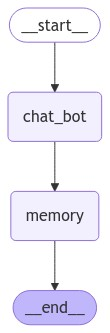

In [22]:
# Create Graph
builder = StateGraph(MessagesState)
builder.add_node('chat_bot',call_model)
builder.add_node('memory',create_memory)

builder.add_edge(START,'chat_bot')
builder.add_edge('chat_bot','memory')
builder.add_edge('memory',END)

graph = builder.compile(checkpointer=memory,store=store)
display(Image(graph.get_graph().draw_mermaid_png()))

#### When we interact with the chatbot, we supply two things.
<ul>
<li><code>Short-term memory</code> : This is a with  in thread memory. A thread id will be passed for persisting the chat history</li>

<li><code>Long-term memory</code>: This is cross thread memory. A user-id will be passed . It is the namespace for longterm memory for the user</li>
</ul>

In [24]:
config = {'configurable':{'thread_id':"1",'user_id':"1"}}
 
# runnig the graph in stream mode
input_message = HumanMessage(content="Hi, My name is Aditya. And I love riding Cars.")
for chunk in graph.stream({'messages':input_message},config = config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Hi, My name is Aditya. And I love riding Cars.
================================== Ai Message ==================================

Hi Aditya! It's great to meet you. Since you love riding cars, do you have a favorite type of car or a specific model you’re passionate about?


In [25]:
input_message = HumanMessage(content="Yes swift is my favourite car.")
for chunk in graph.stream({'messages':input_message},config = config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Yes swift is my favourite car.
================================== Ai Message ==================================

The Maruti Suzuki Swift is a fantastic choice! It's known for its sporty look, compact size, and great fuel efficiency. Do you have any memorable experiences or trips you've taken in your Swift?


In [27]:
user_id  = "1"
namespace = ("memory",user_id)
existing_memory = store.get(namespace,"user_memory")
existing_memory.dict()

{'value': {'memory': 'User Information:\n- Name: Aditya\n- Interests: Riding cars\n- Favorite Car: Maruti Suzuki Swift'},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-24T12:13:48.353127+00:00',
 'updated_at': '2024-11-24T12:15:34.950175+00:00'}

In [29]:
config = {'configurable':{'thread_id':"3",'user_id':"1"}}
input_message = HumanMessage(content = "Can you suggest me a good car?")
for chunk in graph.stream({'messages':input_message},config=config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Can you suggest me a good car?
================================== Ai Message ==================================

Since you're a fan of the Maruti Suzuki Swift, you might enjoy a few other options that offer a similar blend of performance, style, and practicality. Here are some suggestions:

1. **Hyundai i20** - Known for its premium features and spacious interior, it offers a comfortable ride with efficient engine options.

2. **Tata Altroz** - A stylish hatchback with a strong build quality and advanced safety features. It also comes with a spacious cabin and good fuel efficiency.

3. **Honda Jazz** - Offers a versatile interior with its Magic Seat feature, providing ample space for both passengers and cargo. It's known for its reliability and efficient engines.

4. **Kia Sonet** - If you're open to a compact SUV, the Sonet provides a bold design, a sporty feel, and numerous features, making it a great c

### In Simple Term
<p> We can say that. A <code>checkpointer</code> is only accessable within thread which is a <code>short term memory</code>. But on the other hand a store is accessable between threads and it is <code>Long term memory</code></p>